Projeto desenvolvido por: [Gabriel Pacheco](https://linkedin.com/in/gabriel-pacheco37)

Disponível no repositório do github: [Credit Project](https://github.com/gasp37/credit-project/tree/main)

---
## Análise de crédito baseada em modelos estatísticos

Criação de um modelo estatístico que irá prever se um cliente tem a propensão a honrar um empréstimo.

**Hipótese:** É possível criar um modelo estatístico de análise de crédito que apresente maior assertividade que o modelo `AS-IS`.

**Conclusão:** Foi criado um modelo Random Forest com um recall de 58%, e que nas mesmas condições do modelo `AS-IS` trouxe uma redução de R$3,11 milhões na dívida total.

---
Para alcançarmos este resultados vamos seguir os seguintes passos:
 - Tratamento e análise inicial dos dados
 - Criação do modelo baseline
 - Refinamento das soluções
 - Análise dos resultados

In [62]:
# Tratamento dos dados
import pandas as pd
import numpy as np

# Visualização dos dados
import matplotlib.pyplot as plt
import seaborn as sns

# Pré-processamento e machine learning
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler

# Outros
from joblib import dump
import warnings

warnings.filterwarnings("ignore")
pd.set_option("max_columns", None)
sns.set_theme()

### Tratamento e análise inicial dos dados

Nesta etapa nós conhecemos melhor os dados e tratamos algumas anomalias.

---

Conclusão do tratamento e análise inicial dos dados: 
- Foram identificadas 144k linhas e 151 colunas no dataset inicial.
- As classes se encontram desbalanceadas com 4 maus pagadores para cada 1 bom pagador.
- Foram excluídas as colunas ID, REF_DATE e VAR149, que não apresentam valor significativo para o modelo.
- Foi identificado que todas as linhas possuiam pelo menos um valor nulo e estes valores foram tratados da seguinte forma:
    - Foram excluídas 59 colunas com mais de 10% de valores nulos.
    - Foram excluídas 3545 linhas com mais de 10% de valores nulos.
    - Foram excluídas linhas com TARGET positivo e com valores nulos.
    - Os demais valores foram inseridos usando KNNImputer.
- Foi realizado o encoding das variáveis categóricas respeitando a sua ordem natural.
- Existe uma forte correlação entre cada um dos dois grupos de variáveis ordinais.
- A variável TARGET apresentou baixa correlação com as demais variáveis do dataset, o que pode prejudicar as previsões.
- O dataset de teste foi processado para se encontrar no mesmo padrão do dataset de treino.

In [63]:
train_file = "../datasets/credit_01/train.csv"
test_file = "../datasets/credit_01/test.csv"

train_raw = pd.read_csv(train_file)

In [64]:
train_raw.head(5)

,REF_DATE,TARGET,VAR2,IDADE,VAR4,VAR5,VAR6,VAR7,VAR8,VAR9,VAR10,VAR11,VAR12,VAR13,VAR14,VAR15,VAR16,VAR17,VAR18,VAR19,VAR20,VAR21,VAR22,VAR23,VAR24,VAR25,VAR26,VAR27,VAR28,VAR29,VAR30,VAR31,VAR32,VAR33,VAR34,VAR35,VAR36,VAR37,VAR38,VAR39,VAR40,VAR41,VAR42,VAR43,VAR44,VAR45,VAR46,VAR47,VAR48,VAR49,VAR50,VAR51,VAR52,VAR53,VAR54,VAR55,VAR56,VAR57,VAR58,VAR59,VAR60,VAR61,VAR62,VAR63,VAR64,VAR65,VAR66,VAR67,VAR68,VAR69,VAR70,VAR71,VAR72,VAR73,VAR74,VAR75,VAR76,VAR77,VAR78,VAR79,VAR80,VAR81,VAR82,VAR83,VAR84,VAR85,VAR86,VAR87,VAR88,VAR89,VAR90,VAR91,VAR92,VAR93,VAR94,VAR95,VAR96,VAR97,VAR98,VAR99,VAR100,VAR101,VAR102,VAR103,VAR104,VAR105,VAR106,VAR107,VAR108,VAR109,VAR110,VAR111,VAR112,VAR113,VAR114,VAR115,VAR116,VAR117,VAR118,VAR119,VAR120,VAR121,VAR122,VAR123,VAR124,VAR125,VAR126,VAR127,VAR128,VAR129,VAR130,VAR131,VAR132,VAR133,VAR134,VAR135,VAR136,VAR137,VAR138,VAR139,VAR140,VAR141,VAR142,VAR143,VAR144,VAR145,VAR146,VAR147,VAR148,VAR149,ID
0,2017-01-25 00:00:00+00:00,1,F,24.471,NaN,SP,-23.549841,-46.959865,E,E,ALTA,0.0,0.095,NaN,0.222,0.192,0.083333,NaN,0.983562,2.200000,NaN,NaN,0.125,NaN,0.017,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.378548,0.451697,0.438720,0.499008,NaN,NaN,NaN,NaN,1.000,NaN,S,N,N,N,N,S,N,N,N,N,N,S,S,N,N,N,N,MEDIA,ALTA,MEDIA,ALTA,MEDIA,MEDIA,ALTA,ALTA,ALTA,MEDIA,ALTA,ALTA,MEDIA,ALTA,MEDIA,MEDIA,ALTA,ALTA,ALTA,ALTA,MEDIA,MEDIA,MEDIA,ALTA,BAIXISSIMA,MEDIA,MEDIA,ALTA,ALTA,ALTA,MEDIA,ALTA,ALTA,MEDIA,ALTISSIMA,MEDIA,LONGE,MEDIO,LONGE,LONGE,LONGE,MEDIO,LONGE,PROXIMO,MEDIO,MEDIO,LONGE,MEDIO,MEDIO,LONGE,LONGE,MEDIO,MEDIO,LONGE,MUITO LONGE,MEDIO,LONGE,LONGE,LONGE,MEDIO,MEDIO,MEDIO,LONGE,LONGE,MEDIO,LONGE,MEDIO,MEDIO,MEDIO,LONGE,PROXIMO,LONGE,MEDIO,LONGE,MEDIO,1399.037809,E,NaN,NaN,NaN,NaN,102,EMAIL INEXISTENTE,2.6.1,280764
1,2017-04-03 00:00:00+00:00,1,F,35.041,NaN,BA,-12.924251,-38.487840,E,E,ALTA,0.0,0.005,NaN,0.120,NaN,0.166667,NaN,1.101370,NaN,NaN,NaN,NaN,NaN,0.017,NaN,NaN,NaN,0.0,NaN,0.063,NaN,NaN,NaN,NaN,S,S,198.0,NaN,0.476678,0.401271,0.393429,0.508360,NaN,NaN,NaN,NaN,0.000,NaN,S,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,ALTA,BAIXISSIMA,ALTISSIMA,ALTA,ALTISSIMA,ALTA,ALTA,ALTA,ALTISSIMA,ALTISSIMA,ALTISSIMA,MEDIA,ALTISSIMA,ALTISSIMA,ALTA,ALTA,ALTISSIMA,ALTA,ALTISSIMA,ALTISSIMA,ALTA,ALTA,ALTISSIMA,ALTA,ALTISSIMA,ALTISSIMA,ALTISSIMA,BAIXISSIMA,ALTISSIMA,ALTA,ALTA,ALTA,ALTISSIMA,ALTA,ALTISSIMA,ALTA,MEDIO,MEDIO,PROXIMO,MEDIO,LONGE,LONGE,LONGE,PROXIMO,MEDIO,PROXIMO,MEDIO,MEDIO,MEDIO,PROXIMO,MEDIO,PROXIMO,MUITO PROXIMO,PROXIMO,MUITO LONGE,PROXIMO,MEDIO,MEDIO,MEDIO,MEDIO,LONGE,PROXIMO,MEDIO,PROXIMO,LONGE,PROXIMO,MEDIO,MEDIO,MEDIO,PROXIMO,PROXIMO,MEDIO,MEDIO,MEDIO,MEDIO,1516.196234,E,NaN,NaN,NaN,NaN,102,EMAIL INEXISTENTE,2.6.1,270129
2,2017-07-13 00:00:00+00:00,1,M,63.518,NaN,PI,-5.063743,-42.761499,E,E,MEDIA,0.0,NaN,NaN,0.156,0.117,NaN,NaN,1.446575,1.446575,NaN,NaN,0.125,NaN,0.017,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.532506,0.484427,0.546715,0.480883,NaN,NaN,NaN,NaN,1.000,NaN,S,N,N,N,N,N,N,S,N,N,N,N,N,N,N,N,N,ALTISSIMA,ALTA,ALTA,ALTA,ALTISSIMA,ALTISSIMA,ALTA,BAIXISSIMA,ALTISSIMA,ALTISSIMA,ALTA,ALTA,ALTISSIMA,BAIXISSIMA,ALTISSIMA,ALTISSIMA,ALTA,MEDIA,ALTA,ALTA,BAIXISSIMA,ALTISSIMA,ALTA,ALTISSIMA,ALTISSIMA,ALTA,ALTISSIMA,ALTISSIMA,ALTA,ALTA,ALTISSIMA,MEDIA,ALTISSIMA,ALTISSIMA,ALTISSIMA,ALTISSIMA,LONGE,MEDIO,LONGE,MEDIO,PROXIMO,MEDIO,PROXIMO,MUITO PROXIMO,LONGE,PROXIMO,PROXIMO,MEDIO,LONGE,MUITO LONGE,PROXIMO,LONGE,MEDIO,PROXIMO,MUITO LONGE,LONGE,PROXIMO,MUITO LONGE,MEDIO,PROXIMO,MEDIO,PROXIMO,LONGE,LONGE,MEDIO,PROXIMO,MEDIO,MEDIO,PROXIMO,PROXIMO,PROXIMO,LONGE,MEDIO,MEDIO,MEDIO,1727.153575,E,NaN,NaN,NaN,NaN,102,EMAIL INEXISTENTE,2.6.1,257358
3,2017-01-27 00:00:00+00:00,1,F,47.452,NaN,PA,-0.623754,-47.345800,NaN,E,ALTISSIMA,NaN,NaN,NaN,0.096,0.022,NaN,NaN,0.482192,0.482192,0.011,NaN,0.125,NaN,0.138,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S,S,227.0,NaN,0.273552,0.533198,0.786395,0.462936,NaN,NaN,NaN,NaN,0.000,NaN,S,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,MEDIA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,MEDIA,MEDIA,BAI

O dataset train_raw possui 144469 linhas e 151 colunas.
Classes positivas (mau pagador): 114400
Classes negativas (bom pagador): 30069


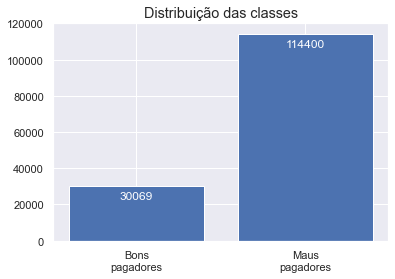

In [65]:
shape = train_raw.shape
label_counts = train_raw["TARGET"].value_counts()

print(f"""O dataset train_raw possui {shape[0]} linhas e {shape[1]} colunas.
Classes positivas (mau pagador): {label_counts[1]}
Classes negativas (bom pagador): {label_counts[0]}""")

bars = plt.bar(label_counts.index, label_counts)
plt.xticks([0, 1], ["Bons\npagadores", "Maus\npagadores"])
plt.bar_label(bars, padding=-15, c="#ffffff")
plt.title("Distribuição das classes", fontsize="large")

plt.show()

In [66]:
train_raw.describe()

,TARGET,IDADE,VAR6,VAR7,VAR11,VAR12,VAR13,VAR14,VAR15,VAR16,VAR17,VAR18,VAR19,VAR20,VAR21,VAR22,VAR23,VAR24,VAR25,VAR26,VAR27,VAR28,VAR29,VAR30,VAR37,VAR39,VAR40,VAR41,VAR42,VAR44,VAR46,VAR47,VAR141,VAR145,VAR146,VAR147,ID
count,144469.000000,127914.000000,140434.000000,140434.000000,89263.000000,78599.000000,18585.000000,113925.00000,70000.000000,53869.000000,18585.000000,113925.000000,70000.000000,13735.000000,18657.000000,70092.000000,18585.000000,116416.000000,70000.000000,1191.000000,1230.000000,15321.000000,29555.000000,15321.000000,29777.000000,144380.000000,140529.000000,140924.000000,127926.000000,481.000000,363.000000,144469.000000,144469.000000,781.000000,196.000000,144469.000000,144469.000000
mean,0.791865,42.127893,-14.426873,-45.904869,0.234991,0.223218,0.315297,0.14781,0.185523,2.060772,2.140792,0.977187,1.239946,0.047386,0.349051,0.212421,0.088846,0.080561,0.061717,0.351974,0.017718,0.003988,0.144825,0.194908,150.885952,0.460820,0.531776,0.631543,0.504813,1700.336944,6967.353609,0.256728,1853.693120,4144.525941,1888.522194,101.841613,165360.469831
std,0.405975,15.219360,8.995527,7.525072,0.627351,0.257485,0.241704,0.12373,0.195338,3.202829,2.170238,0.496084,1.118753,0.126345,0.192901,0.176246,0.132661,0.139510,0.126570,0.223649,0.032118,0.038391,0.149063,0.161765,82.522220,0.144096,0.116050,0.222453,0.069707,2006.519561,4976.013549,0.406769,906.316882,4227.651991,2881.474614,0.540083,95570.299396
min,0.000000,18.014000,-33.521563,-72.900276,-4.000000,0.000000,0.000000,0.00000,0.000000,0.083333,0.002740,0.002740,0.002740,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22.000000,0.049309,0.208688,0.000000,0.006658,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100.000000,1.000000
25%,1.000000,30.008000,-22.840241,-49.903564,0.000000,0.045000,0.056000,0.10200,0.078000,0.250000,0.493151,0.503899,0.347735,0.000000,0.250000,0.125000,0.011000,0.000000,0.000000,0.167000,0.000000,0.000000,0.042000,0.125000,102.000000,0.363536,0.448221,0.441037,0.463619,642.000000,3555.710000,0.000000,1513.227400,1683.570000,0.000000,102.000000,82492.000000
50%,1.000000,39.830000,-13.029732,-46.572594,0.000000,0.127000,0.319000,0.12700,0.111000,0.833333,0.819178,1.052055,1.139726,0.011000,0.250000,0.125000,0.043000,0.034000,0.000000,0.333000,0.000000,0.000000,0.104000,0.125000,134.000000,0.462267,0.510023,0.542772,0.496036,769.000000,5331.430000,0.003000,1627.157652,3024.480000,937.000000,102.000000,165419.000000
75%,1.000000,53.030000,-6.355728,-39.030381,0.000000,0.286000,0.508000,0.15400,0.153000,2.416667,4.093151,1.391781,1.460274,0.033000,0.500000,0.250000,0.096000,0.086000,0.065000,0.500000,0.033000,0.000000,0.188000,0.250000,182.000000,0.557545,0.582548,0.897432,0.522872,1747.500000,9459.920000,0.423000,1820.670284,5157.060000,2263.927500,102.000000,248132.000000
max,1.000000,106.904000,4.478585,-32.429516,4.000000,1.000000,1.000000,1.00000,1.000000,15.999999,8.999999,2.471023,7.406250,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.200000,1.000000,1.000000,1.000000,852.000000,0.970921,0.920685,1.000000,0.910865,17374.940000,30262.370000,1.000000,46685.420000,46685.420000,17229.200000,102.000000,330581.000000


Algumas colunas não são relevantes para o nosso modelo preditivo, então podemos começar por excluir essas colunas:
- REF_DATE é a data de referência da solicitação do empréstimo.
- ID é o identificador individual de cada cliente.
- VAR149 é uma constante.

In [67]:
train_treated = train_raw.drop(columns=["REF_DATE", "ID", "VAR149"])

Análise de valores ausentes:

In [68]:
null_rows = len(train_treated[train_treated.isna().any(axis=1)])
print(f"Existem {null_rows} linhas com valores nulos de um total de {len(train_treated)} linhas. Equivalente a {round(null_rows/len(train_treated)*100, 2)}% do dataset.")

Existem 144469 linhas com valores nulos de um total de 144469 linhas. Equivalente a 100.0% do dataset.


Pudemos constatar que todas as linhas do dataset possuem pelo menos um valor nulo. Para tratar isso vamos seguir dois passos:
- Identificar e remover colunas com grande percentual de valores ausentes.
- Identificar e remover linhas com grande percentual de valores ausentes.
- Inserir os valores nulos restantes usando KNNImputer.

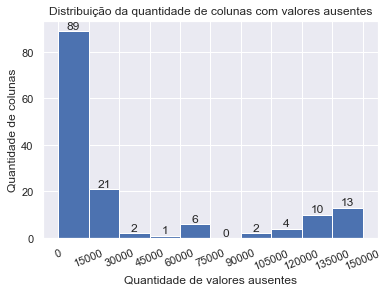

De 148 colunas, 59 possuem 10.0% ou mais de valores ausentes.
Estas colunas serão excluídas, visto que apresentam pouco valor para o nosso modelo.


In [70]:
nulls_by_column = train_treated.isnull().sum().sort_values(ascending=False)
nulls_by_column_grouped = nulls_by_column.groupby(nulls_by_column).count()
bins = np.arange(0, 150001, 15000)

values, bins, bars = plt.hist(nulls_by_column_grouped.index, weights=nulls_by_column_grouped.values, bins=bins)
plt.xticks(bins, rotation=22.5)
plt.xlabel("Quantidade de valores ausentes")
plt.ylabel("Quantidade de colunas")
plt.title("Distribuição da quantidade de colunas com valores ausentes")
plt.bar_label(bars)

plt.show()

NULLS_BY_COLUMN_THRESHOLD = 0.10
total_rows = len(train_treated)
total_cols = len(train_treated.columns)

print(f"""De {total_cols} colunas, {nulls_by_column[nulls_by_column > total_rows * NULLS_BY_COLUMN_THRESHOLD].count()} possuem {NULLS_BY_COLUMN_THRESHOLD*100}% ou mais de valores ausentes.
Estas colunas serão excluídas, visto que apresentam pouco valor para o nosso modelo.""")

In [71]:
train_treated = train_treated.drop(columns=nulls_by_column[nulls_by_column > total_rows * NULLS_BY_COLUMN_THRESHOLD].index)

null_rows = len(train_treated[train_treated.isna().any(axis=1)])
print(f"Existem {null_rows} linhas com valores nulos de um total de {len(train_treated)} linhas. Equivalente a {round(null_rows/len(train_treated)*100, 2)}% do dataset.")

Existem 4382 linhas com valores nulos de um total de 144469 linhas. Equivalente a 3.03% do dataset.


Perfeito, ao definirmos um limite máximo de 10% de valores ausentes por coluna, já conseguimos reduzir bastante a proporção de nulos no dataset. Vamos para a próxima etapa e verificar a proporção de nulos por linhas.

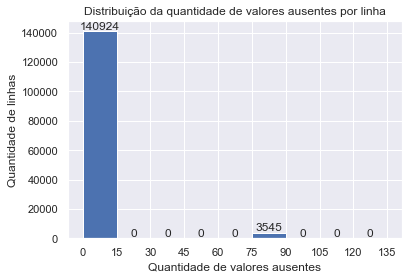

De 144469 linhas, 3545 possuem 10.0% ou mais de valores ausentes.
Estas linhas serão excluídas, visto que apresentam pouco valor para o nosso modelo.


In [72]:
nulls_by_row = train_treated.isnull().sum(axis=1).sort_values(ascending=False)
nulls_by_row_grouped = nulls_by_row.groupby(nulls_by_row).count()
bins = np.arange(0, 150, 15)

values, bins, bars = plt.hist(nulls_by_row_grouped.index, weights=nulls_by_row_grouped.values, bins=bins)
plt.xticks(bins)
plt.xlabel("Quantidade de valores ausentes")
plt.ylabel("Quantidade de linhas")
plt.title("Distribuição da quantidade de valores ausentes por linha")
plt.bar_label(bars)

plt.show()

NULLS_BY_ROW_THRESHOLD = 0.10
total_rows = len(train_treated)
total_cols = len(train_treated.columns)

print(f"""De {total_rows} linhas, {nulls_by_row[nulls_by_row > total_cols * NULLS_BY_ROW_THRESHOLD].count()} possuem {NULLS_BY_ROW_THRESHOLD*100}% ou mais de valores ausentes.
Estas linhas serão excluídas, visto que apresentam pouco valor para o nosso modelo.""")

In [73]:
train_treated = train_treated.drop(index=nulls_by_row[nulls_by_row > total_cols * NULLS_BY_ROW_THRESHOLD].index)

null_rows = len(train_treated[train_treated.isna().any(axis=1)])
print(f"Existem {null_rows} linhas com valores nulos de um total de {len(train_treated)} linhas. Equivalente a {round(null_rows/len(train_treated)*100, 2)}% do dataset.")

Existem 837 linhas com valores nulos de um total de 140924 linhas. Equivalente a 0.59% do dataset.


Antes de partirmos para inserir os valores ausentes que sobraram é importante considerar como as classes do dataset estão fortemente desbalanceadas. Para cada bom pagador, temos quase 4 maus pagadores. Além disso, temos um grande volume de dados, por isso podemos excluir as linhas de maus pagadores com valores ausentes e focar em inserir os dados nas linhas dos bons pagadores. 

In [74]:
rows_to_drop = train_treated[train_treated["TARGET"]==1].isnull().any(axis=1)
rows_to_drop = rows_to_drop[rows_to_drop == True]

train_treated = train_treated.drop(index = rows_to_drop.index)

Perfeito, agora que excluímos as colunas positivas com valores ausentes, podemos partir para inserir os valores ausentes restantes. Para as variáveis numéricas podemos utilizar o KNNImputer, para as categóricas iremos fazer esse tratamento quando realizarmos a transformação para variáveis numéricas.

In [75]:
def impute_missing_values(dataset):
    imputer = KNNImputer()
    imputer.fit(dataset.iloc[:,:])
    dataset.iloc[:,:] = imputer.transform(dataset.iloc[:,:])

    return dataset

In [76]:
numeric_cols = train_treated.select_dtypes(include="number").columns.drop("TARGET")

train_treated[numeric_cols] = impute_missing_values(train_treated[numeric_cols])

_nulls_by_column = train_treated.isnull().sum().sort_values(ascending=False)
_nulls_by_column[_nulls_by_column>0]

VAR5      83
VAR9      73
VAR10     63
VAR142    32
dtype: int64

Perfeito, os valores nulos restantes são de variáveis categóricas que serão tratadas depois de ser feito o encoding.

Para tratarmos as variáveis categórias precisamos entender que existem 3 grupos de variáveis no nosso dataset:
- Variáveis nominais: Como a VAR5 e VAR148. Que não possuem uma ordem natural nas categorias, e por isso serão tratadas usando OrdinalEncoder
- Variáveis ordinais com a classificação: BAIXISSIMA, BAIXA, MEDIA, ALTA, ALTISSIMA que serão tratadas com uma função própria
- Variáveis ordinais com a classificação: MUITO PROXIMO, PROXIMO, MEDIO, LONGE, MUITO LONGE que serão tratadas com uma função própria
- Variáveis ordinais com a classificação: A, B, C, D, E que serão tratadas com uma função própria

In [77]:
def ordinal_encoding(dataset:pd.DataFrame, columns:list, values_to_replace:dict):
    return dataset[columns].replace(values_to_replace)

nominal_features = ["VAR5", "VAR148"]
ordinal_features1 = ["VAR10", "VAR66", "VAR67", "VAR68", "VAR69", "VAR70", "VAR71",
       "VAR72", "VAR73", "VAR74", "VAR75", "VAR76", "VAR77", "VAR78", "VAR79",
       "VAR80", "VAR81", "VAR82", "VAR83", "VAR84", "VAR85", "VAR86", "VAR87",
       "VAR88", "VAR89", "VAR90", "VAR91", "VAR92", "VAR93", "VAR94", "VAR95",
       "VAR96", "VAR97", "VAR98", "VAR99", "VAR100", "VAR101"]
ordinal_features2 = ["VAR102", "VAR103", "VAR104", "VAR105", "VAR106", "VAR107", "VAR108", 
       "VAR109", "VAR110", "VAR111", "VAR112", "VAR113", "VAR114", "VAR115", "VAR116",
       "VAR117", "VAR118", "VAR119", "VAR120", "VAR121", "VAR122", "VAR123", "VAR124", 
       "VAR125", "VAR126", "VAR127", "VAR128", "VAR129", "VAR130", "VAR131", "VAR132", 
       "VAR133", "VAR134", "VAR135", "VAR136", "VAR137", "VAR138", "VAR139", "VAR140"]
ordinal_features3 = ["VAR9", "VAR142"]

values_to_replace1 = {"BAIXISSIMA":0, "BAIXA":1, "MEDIA":2, "ALTA":3, "ALTISSIMA":4}
values_to_replace2 = {"MUITO PROXIMO":0, "PROXIMO":1, "MEDIO":2, "LONGE":3, "MUITO LONGE":4}
values_to_replace3 = {"A":0, "B":1, "C":2, "D":3, "E":4}

In [78]:
train_treated[ordinal_features1] = ordinal_encoding(train_treated, ordinal_features1, values_to_replace1)
train_treated[ordinal_features2] = ordinal_encoding(train_treated, ordinal_features2, values_to_replace2)
train_treated[ordinal_features3] = ordinal_encoding(train_treated, ordinal_features3, values_to_replace3)

In [79]:
def encode_data(dataset:pd.DataFrame, features:list):
    encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    encoder.fit(dataset[features])
    return encoder, encoder.transform(dataset[features])

encoder, train_treated[nominal_features] = encode_data(train_treated, nominal_features)

train_treated[["VAR5", "VAR9", "VAR10", "VAR142"]] = impute_missing_values(train_treated[["VAR5", "VAR9", "VAR10", "VAR142"]])

In [80]:
train_treated.head(5)

,TARGET,VAR5,VAR6,VAR7,VAR9,VAR10,VAR39,VAR40,VAR41,VAR47,VAR66,VAR67,VAR68,VAR69,VAR70,VAR71,VAR72,VAR73,VAR74,VAR75,VAR76,VAR77,VAR78,VAR79,VAR80,VAR81,VAR82,VAR83,VAR84,VAR85,VAR86,VAR87,VAR88,VAR89,VAR90,VAR91,VAR92,VAR93,VAR94,VAR95,VAR96,VAR97,VAR98,VAR99,VAR100,VAR101,VAR102,VAR103,VAR104,VAR105,VAR106,VAR107,VAR108,VAR109,VAR110,VAR111,VAR112,VAR113,VAR114,VAR115,VAR116,VAR117,VAR118,VAR119,VAR120,VAR121,VAR122,VAR123,VAR124,VAR125,VAR126,VAR127,VAR128,VAR129,VAR130,VAR131,VAR132,VAR133,VAR134,VAR135,VAR136,VAR137,VAR138,VAR139,VAR140,VAR141,VAR142,VAR147,VAR148
0,1,25.0,-23.549841,-46.959865,4.0,3.0,0.378548,0.451697,0.438720,1.000,2,3,2,3,2,2,3,3,3,2,3,3,2,3,2,2,3,3,3,3,2,2,2,3,0,2,2,3,3,3,2,3,3,2,4,2,3,2,3,3,3,2,3,1,2,2,3,2,2,3,3,2,2,3,4,2,3,3,3,2,2,2,3,3,2,3,2,2,2,3,1,3,2,3,2,1399.037809,4.0,102.0,0.0
1,1,4.0,-12.924251,-38.487840,4.0,3.0,0.476678,0.401271,0.393429,0.000,3,0,4,3,4,3,3,3,4,4,4,2,4,4,3,3,4,3,4,4,3,3,4,3,4,4,4,0,4,3,3,3,4,3,4,3,2,2,1,2,3,3,3,1,2,1,2,2,2,1,2,1,0,1,4,1,2,2,2,2,3,1,2,1,3,1,2,2,2,1,1,2,2,2,2,1516.196234,4.0,102.0,0.0
2,1,16.0,-5.063743,-42.761499,4.0,2.0,0.532506,0.484427,0.546715,1.000,4,3,3,3,4,4,3,0,4,4,3,3,4,0,4,4,3,2,3,3,0,4,3,4,4,3,4,4,3,3,4,2,4,4,4,4,3,2,3,2,1,2,1,0,3,1,1,2,3,4,1,3,2,1,4,3,1,4,2,1,2,1,3,3,2,1,2,2,1,1,1,3,2,2,2,1727.153575,4.0,102.0,0.0
3,1,13.0,-0.623754,-47.345800,4.0,4.0,0.273552,0.533198,0.786395,0.000,2,0,0,0,2,2,0,2,2,0,0,0,0,0,0,1,0,0,0,0,2,3,1,2,0,1,0,0,2,0,1,0,0,2,0,0,3,0,3,4,4,4,0,4,3,0,4,4,4,3,4,4,4,1,4,1,3,4,0,4,3,4,4,4,4,0,4,4,4,4,4,4,4,3,4,1627.157652,4.0,102.0,0.0
4,1,22.0,-28.460032,-52.820856,4.0,4.0,0.682983,0.770025,0.959874,0.503,2,0,0,2,2,2,0,0,2,2,2,0,2,0,0,2,0,0,0,2,2,2,2,2,0,2,2,0,2,0,2,2,0,2,0,0,3,3,3,4,3,4,3,3,4,3,3,3,4,4,0,4,3,4,1,3,3,3,3,3,3,3,3,3,4,3,3,3,4,0,3,4,4,4,0,2133.992676,3.0,102.0,0.0


In [81]:
train_treated.describe()

,TARGET,VAR5,VAR6,VAR7,VAR9,VAR10,VAR39,VAR40,VAR41,VAR47,VAR66,VAR67,VAR68,VAR69,VAR70,VAR71,VAR72,VAR73,VAR74,VAR75,VAR76,VAR77,VAR78,VAR79,VAR80,VAR81,VAR82,VAR83,VAR84,VAR85,VAR86,VAR87,VAR88,VAR89,VAR90,VAR91,VAR92,VAR93,VAR94,VAR95,VAR96,VAR97,VAR98,VAR99,VAR100,VAR101,VAR102,VAR103,VAR104,VAR105,VAR106,VAR107,VAR108,VAR109,VAR110,VAR111,VAR112,VAR113,VAR114,VAR115,VAR116,VAR117,VAR118,VAR119,VAR120,VAR121,VAR122,VAR123,VAR124,VAR125,VAR126,VAR127,VAR128,VAR129,VAR130,VAR131,VAR132,VAR133,VAR134,VAR135,VAR136,VAR137,VAR138,VAR139,VAR140,VAR141,VAR142,VAR147,VAR148
count,140238.000000,140238.000000,140238.000000,140238.000000,140238.000000,140238.000000,140238.000000,140238.000000,140238.000000,140238.000000,140238.000000,140238.000000,140238.000000,140238.000000,140238.000000,140238.000000,140238.000000,140238.000000,140238.000000,140238.000000,140238.000000,140238.000000,140238.000000,140238.000000,140238.000000,140238.000000,140238.000000,140238.000000,140238.000000,140238.000000,140238.000000,140238.000000,140238.000000,140238.000000,140238.000000,140238.000000,140238.000000,140238.000000,140238.000000,140238.000000,140238.000000,140238.000000,140238.000000,140238.000000,140238.000000,140238.000000,140238.000000,140238.000000,140238.000000,140238.000000,140238.000000,140238.000000,140238.000000,140238.000000,140238.000000,140238.000000,140238.000000,140238.000000,140238.000000,140238.000000,140238.000000,140238.000000,140238.000000,140238.000000,140238.000000,140238.000000,140238.000000,140238.000000,140238.000000,140238.000000,140238.000000,140238.000000,140238.000000,140238.000000,140238.000000,140238.000000,140238.000000,140238.000000,140238.000000,140238.000000,140238.000000,140238.000000,140238.000000,140238.000000,140238.000000,140238.000000,140238.000000,140238.000000,140238.000000
mean,0.791205,13.817853,-14.420144,-45.902098,3.981805,2.605476,0.461953,0.531744,0.631503,0.259093,2.077176,1.312875,1.760015,1.387292,2.106141,2.250952,1.641310,1.694512,2.101934,2.034299,2.069147,1.634799,1.953237,1.750453,1.585398,2.378293,1.619932,1.688437,1.605357,1.939596,2.068163,2.210599,2.300575,1.879712,0.488256,2.211241,2.081626,1.410217,1.921455,1.615318,2.200951,2.071971,1.945878,2.280309,0.657739,1.873715,2.664670,2.606555,2.648940,2.845413,2.631120,2.697008,2.550578,2.818066,2.691817,2.619647,2.617793,2.606854,2.705194,2.675844,2.405446,2.666260,2.463049,2.569354,3.602276,2.558729,2.625729,2.589113,2.535782,2.541929,2.719677,2.759687,2.561802,2.669455,2.686198,2.554386,2.521535,2.656370,2.606412,2.502731,2.801145,2.800917,2.747180,2.651656,2.574245,1866.160926,3.744280,101.837562,0.923245
std,0.406449,7.941155,8.992878,7.524699,0.181833,1.175452,0.143914,0.116010,0.222425,0.407893,1.456192,1.759422,1.569714,1.605520,1.400302,1.403390,1.572562,1.598919,1.478276,1.490514,1.545617,1.607476,1.495592,1.601159,1.625218,1.373839,1.760511,1.540865,1.757415,1.556775,1.496569,1.400900,1.435697,1.473468,1.309443,1.462740,1.469040,1.764287,1.585713,1.686409,1.412932,1.412833,1.506219,1.446161,1.482684,1.528141,1.107668,1.179206,1.148167,1.063826,1.134389,1.062225,1.145817,0.994290,1.103698,1.125832,1.120377,1.136637,1.074116,1.067544,1.314030,1.185862,1.331160,1.110812,1.017347,1.121395,1.123818,1.159431,1.182384,1.179918,1.029808,1.088097,1.216579,1.100920,1.085398,1.094945,1.212724,1.138199,1.120096,1.217981,1.087478,1.021468,1.049966,1.079266,1.575718,913.749809,0.507601,0.546344,1.189995
min,0.000000,0.000000,-33.521563,-72.900276,0.000000,0.000000,0.049309,0.208688,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,

Nosso dataset de treino está tratado, agora vamos aplicar as mesmas alterações no dataset de teste de forma a manter a padronização nos dados.

No dataset de treino fizemos as seguintes alterações:
- Filtramos apenas as colunas utilizadas no dataset de treino.
- Excluímos as linhas com valores nulos, de forma a manter este dataset o mais puro possível.
- Aplicamos o encoding das variáveis.

In [20]:
test_raw = pd.read_csv("../datasets/credit_01/test.csv")

shape = test_raw.shape
label_counts = test_raw["TARGET"].value_counts()

print(f"""O dataset test_raw possui {shape[0]} linhas e {shape[1]} colunas.
Classes positivas (mau pagador): {label_counts[1]}
Classes negativas (bom pagador): {label_counts[0]}""")

O dataset test_raw possui 71157 linhas e 151 colunas.
Classes positivas (mau pagador): 56347
Classes negativas (bom pagador): 14810


In [21]:
train_columns = train_treated.columns
test_treated = test_raw[train_columns]

nulls_by_row = test_treated.isna().sum(axis=1).sort_values()
test_treated = test_treated.drop(index=nulls_by_row[nulls_by_row>0].index)

test_treated[ordinal_features1] = ordinal_encoding(test_treated, ordinal_features1, values_to_replace1)
test_treated[ordinal_features2] = ordinal_encoding(test_treated, ordinal_features2, values_to_replace2)
test_treated[ordinal_features3] = ordinal_encoding(test_treated, ordinal_features3, values_to_replace3)

test_treated[nominal_features]= encoder.transform(test_treated[nominal_features])

In [22]:
test_treated

,TARGET,VAR5,VAR6,VAR7,VAR9,VAR10,VAR39,VAR40,VAR41,VAR47,VAR66,VAR67,VAR68,VAR69,VAR70,VAR71,VAR72,VAR73,VAR74,VAR75,VAR76,VAR77,VAR78,VAR79,VAR80,VAR81,VAR82,VAR83,VAR84,VAR85,VAR86,VAR87,VAR88,VAR89,VAR90,VAR91,VAR92,VAR93,VAR94,VAR95,VAR96,VAR97,VAR98,VAR99,VAR100,VAR101,VAR102,VAR103,VAR104,VAR105,VAR106,VAR107,VAR108,VAR109,VAR110,VAR111,VAR112,VAR113,VAR114,VAR115,VAR116,VAR117,VAR118,VAR119,VAR120,VAR121,VAR122,VAR123,VAR124,VAR125,VAR126,VAR127,VAR128,VAR129,VAR130,VAR131,VAR132,VAR133,VAR134,VAR135,VAR136,VAR137,VAR138,VAR139,VAR140,VAR141,VAR142,VAR147,VAR148
0,1,25.0,-22.434379,-46.930944,4,2,0.598485,0.381619,0.430834,1.000,3,3,2,3,3,3,3,0,3,2,3,2,3,3,3,3,0,3,0,3,2,3,2,2,0,3,3,0,3,3,2,4,2,2,0,2,3,2,3,1,2,2,2,3,3,2,3,3,2,3,3,3,3,2,4,3,3,3,3,2,3,3,2,2,3,3,3,1,3,2,2,3,2,3,2,1852.386339,4,102,0.0
1,1,15.0,-8.875221,-36.366189,4,4,0.535474,0.891146,0.877869,0.000,0,0,0,0,2,2,0,0,2,0,0,0,0,2,0,2,0,0,0,0,0,2,0,2,0,1,0,0,0,0,2,2,0,1,0,0,3,4,4,4,4,3,4,3,3,4,4,4,3,3,4,3,4,2,4,3,4,4,4,4,3,3,4,4,3,3,4,4,4,4,3,3,3,3,4,1548.109828,4,102,1.0
2,1,13.0,-4.334255,-49.798835,4,4,0.524659,0.691082,0.964479,0.000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,1,3,4,4,4,4,4,4,4,4,4,4,0,4,4,4,4,4,4,4,4,1570.642421,4,102,1.0
3,1,4.0,-14.806605,-39.056107,4,2,0.368047,0.524424,0.418178,0.000,3,4,4,0,3,3,2,3,3,2,3,3,2,3,0,4,0,2,3,3,3,4,4,2,0,3,2,0,3,3,3,3,2,4,0,3,2,3,3,4,2,1,2,3,2,3,3,2,2,2,2,4,1,1,4,1,2,3,2,1,3,3,3,3,3,2,2,2,3,1,4,3,2,2,4,1399.037809,4,102,3.0
4,1,13.0,-1.061619,-46.783011,4,4,0.472500,0.418465,0.936108,0.054,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,4,4,4,4,3,4,4,3,4,4,4,4,3,0,4,4,2,4,1,4,4,4,4,4,4,4,4,4,3,4,4,4,4,4,4,3,4,4,1570.642421,4,102,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71152,1,18.0,-22.865620,-43.309385,4,2,0.238234,0.425725,0.440530,0.058,3,3,4,4,3,2,4,4,3,4,4,4,3,4,3,2,4,3,4,4,3,3,3,4,4,3,3,4,4,4,4,4,4,3,4,3,3,3,3,3,1,2,3,2,3,3,3,3,2,2,4,2,0,1,4,1,2,2,3,3,2,1,3,2,2,2,1,1,3,3,1,2,1,2,2,1560.669227,4,102,1.0
71153,1,25.0,-21.754778,-48.831698,4,4,0.296611,0.554116,0.622775,0.000,2,0,0,3,2,2,0,0,2,2,0,0,2,0,0,3,0,2,0,2,2,2,2,2,0,3,2,0,0,0,2,4,2,3,0,2,4,3,3,3,3,2,3,3,3,3,3,4,4,3,4,3,3,4,4,4,3,3,3,3,3,4,3,3,4,4,3,3,3,4,3,3,3,3,0,1428.485398,4,102,3.0
71154,1,25.0,-23.928915,-47.071492,4,4,0.511118,0.562130,0.880201,0.000,0,0,0,3,2,2,0,0,2,2,2,0,2,2,0,2,3,0,0,2,2,2,2,0,0,2,2,0,2,0,2,3,0,2,0,0,4,3,3,3,4,4,3,4,4,3,3,2,3,3,4,2,3,2,4,2,3,3,3,3,4,2,3,1,3,3,3,3,4,3,3,4,4,4,0,1407.978124,4,102,0.0
71155,1,15.0,-8.656919,-36.323857,4,4,0.443021,0.872795,0.962416,0.053,2,0,0,3,0,2,0,0,0,0,0,0,0,2,0,2,0,0,0,0,0,2,2,0,0,2,2,0,0,3,2,0,0,2,0,0,4,4,3,4,4,4,4,4,4,4,4,4,3,3,4,3,3,2,4,3,4,4,3,4,4,3,4,3,3,3,4,4,4,4,3,3,3,4,0,1376.253182,4,102,0.0


---

**Análise de correlação das variáveis**

Fazendo uma análise na correlação da variáveis tiramos algumas conclusões:
- Existe uma forte correlação dentro dos dois grupos de variáveis ordinais, isto pode ser um problema para o nosso modelo preditivo pois acaba gerando redundância e um víes no modelo.
- A variável TARGET apresentou baixa correlação com as demais variáveis do dataset, o que também pode prejudicar as previsões.

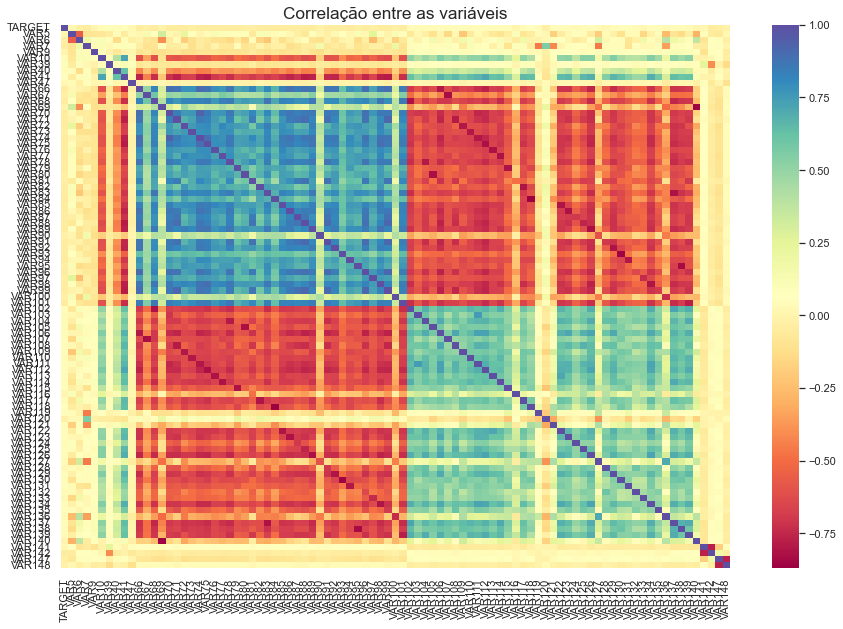

In [159]:
train_corr = train_treated.corr()

f, ax = plt.subplots(figsize=(15,10))
sns.heatmap(train_corr,
            xticklabels=train_corr.columns.values,
            yticklabels=train_corr.columns.values,
            cmap="Spectral")
plt.title("Correlação entre as variáveis", fontsize="x-large")


plt.show()

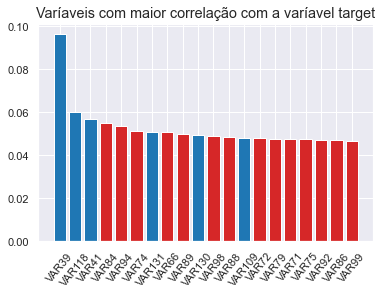

In [243]:
target_corr = pd.DataFrame(train_corr["TARGET"])\
                .drop(index="TARGET")
target_corr["COLOR"] = target_corr["TARGET"].apply(lambda x: "tab:blue" if x > 0 else "tab:red")
target_corr["TARGET"] = target_corr["TARGET"].abs()
target_corr_top20 = target_corr.sort_values(by="TARGET", ascending=False).head(20)

fig, ax = plt.subplots()

x=target_corr_top20.index
height= target_corr_top20.TARGET.values
color = target_corr_top20.COLOR.values

ax.bar(x = x,
        height = height,
        color=color)
plt.xticks(x = x, rotation=50)
plt.title("Varíaveis com maior correlação com a varíavel target", fontsize="large")

plt.show()

Nossos datasets de treino e teste estão prontos, podemos então partir para a próxima etapa de criação do modelo baseline.

### Criação do modelo baseline

Nesta etapa criamos o modelo que servirá de base para as próximas etapas. É um modelo mais simples, sem balanceamento de classes ou outros pré-processamentos.

---
**Considerações sobre a avaliação:**

Para desenvolver o modelo, é importante entender a fundo o problema do negócio sob a ótica da ciência de dados. Como vimos na descrição do problema, o nosso objetivo é auxiliar a empresa a minimizar a quantidade de inadimplentes, e consequentemente a dívida total, enquanto maximiza a quantidade de empréstimos. Para isso vamos visualizar os possíveis resultados do nosso modelo de acordo com uma matriz de confusão.
- Verdadeiro Negativo: O modelo **previu corretamente** que uma pessoa seria uma **boa pagadora** e por isso **não teve dívida.** Este seria o melhor cenário.
- Verdadeiro Positivo: O modelo **previu corretamente** que uma pessoa seria uma **má pagadora**, não emprestou dinheiro e por isso **não teve dívida.** Cenário positivo.
- Falso Positivo: O modelo **previu erroneamente** que uma pessoa seria uma **má pagadora**, não emprestou dinheiro, **não teve dívida** mas **perdeu um bom cliente**. Cenário neutro.
- Falso Negativo: O modelo **previu erroneamente** que uma pessoa seria uma **boa pagadora**, emprestou dinheiro e **teve dívida.** Pior cenário possível.

Como nosso pior cenário é um alto número de Falsos Negativos, **utilizamos o recall como principal métrica**, visto que ele busca reduzir a quantidade de FNs, alinhado com o **Negative Predictive Value** que nos ajuda a máximizar os TNs.

Além disso, para nos ajudar a avaliar o desempenho do modelo, criamos uma função que irá indicar **o percentual de dívida por crédito aprovado (PDCA)**, que usamos como **métrica de negócio**. Esta métrica consiste na função: 

pdca = (fn * 1000)/((tn + fn) * 1000)

Onde fn são os falsos negativos, tn os verdadeiros negativos e 1000 o valor padronizado dos empréstimos de acordo com o problema do negócio.

Também fizemos uma projeção com base no modelo AS-IS no dataset de treino para saber qual seria a dívida total utilizando o modelo atual e conseguimos os seguintes resultados:

- Total de pessoas no dataset de teste: 69047
- Pessoas aptas para receber o empréstimo segundo o modelo AS-IS: 49852
- Pessoas más pagadoras que receberam o empréstimo: 41074
- Carteira de crédito aprovada: R$49,852,000
- Dívida total: R$41,074,000
- Percentual de solicitações negadas: 27.80%
- Percentual de dívida pelo crédito aprovado: 82.39%

---

**Resultados do modelo baseline**

Devido à disparidade nas classes do dataset de treino, o nosso modelo foi incapaz de aprender a prever classes negativas, como é possível ver nos resultados abaixo. Apesar de um recall tecnicamente perfeito, o nosso modelo apresentou péssimos resultados, como é evidenciado pela roc_auc e a métrica specificity, esta última métrica é sensível aos TNs que apesar de serem nosso melhor cenário foram um dos pontos fracos do modelo. Antes de partirmos para os próximos modelos é necessário fazer um balanceamento de classes.

Métricas do modelo baseline avaliado pelo dataset de teste:
- true_negatives: 0,
- false_positives: 14376,
- false_negatives: 0,
- true_positives: 54671,
- specificity: 0.0,
- recall: 1.0,
- score: 0.79,
- roc_auc: 0.56

Estas funções vão nos auxiliar a avaliar os vários modelos:

In [23]:
def total_debt(fn):
    return fn*1000

def debt_by_loans(tn, fn):
    return total_debt(fn)/((tn+fn)*1000)

def get_model_metrics(X, y, trained_model):

    results = trained_model.predict(X)

    tn, fp, fn, tp = confusion_matrix(y, results).ravel()
    score = trained_model.score(X, y)
    roc = roc_auc_score(y, trained_model.predict_proba(X)[:,1])
    recall = tp/(tp+fn)
    specificity = tn/(tn+fp)
    precision = tp/(tp+fp)
    f1_score = (2*precision*recall)/(precision+recall)
    npv = tn/(tn+fn)

    metrics = {
        'true_negatives': tn,
        'false_positives': fp,
        'false_negatives': fn,
        'true_positives': tp,
        'specificity': round(specificity, 2),
        'recall': round(recall, 2),
        'negative_predictive_value': round(npv,2),
        'precision': round(precision, 2),
        'f1_score': round(f1_score, 2),
        'score': round(score, 2),
        'roc_auc':round(roc, 2)
    }

    return metrics

def get_model_train_test_metrics(X_train, y_train, X_test, y_test, model):

    train_metrics = get_model_metrics(X_train, y_train, model)
    test_metrics = get_model_metrics(X_test, y_test, model)

    metrics = [{'dataset':'train', 'metrics':train_metrics},
                {'dataset':'test', 'metrics': test_metrics}]

    return metrics

**Avaliação do cenário AS-IS:**
    
Um empréstimo de R$1000 foi concedido a toda a pessoa com mais de 28 anos.

Como a coluna Idade foi excluída anteriormente devido à quantidade de valores nulos, vamos precisar resgatá-la para o nosso dataset de teste. Além disso, como **a idade é o único parâmetro de avaliação no modelo AS-IS**, não faz sentido que esse valor seja inserido de forma artificial. Assim, só estará apto para empréstimo pessoas com a idade válida e acima de 28 anos.

In [24]:
test_with_age = test_treated.join(test_raw["IDADE"])

total_people = len(test_with_age)
people_age_filled = test_with_age["IDADE"].count()
asis_tn = len(test_with_age[(test_with_age["IDADE"]>28.0) & (test_with_age["TARGET"]==0)]) #bons pagadores acima de 28
asis_fn = len(test_with_age[(test_with_age["IDADE"]>28.0) & (test_with_age["TARGET"]==1)]) #maus pagadores acima de 28
asis_tp = len(test_with_age[((test_with_age["IDADE"]<=28.0) | (test_with_age["IDADE"].isnull())) & (test_with_age["TARGET"]==1)]) #maus pagadores com 28 ou menos ou idade nula
asis_fp = len(test_with_age[((test_with_age["IDADE"]<=28.0) | (test_with_age["IDADE"].isnull())) & (test_with_age["TARGET"]==0)]) #bons pagadores com 28 ou menos ou idade nula
people_age_above_28 = len(test_with_age[test_with_age["IDADE"]>28.0])
good_payers_above_28 = len(test_with_age[(test_with_age["IDADE"]>28.0) & (test_with_age["TARGET"]==0)])

print(f"""
Total de pessoas: {total_people}
Pessoas com a idade preenchida: {people_age_filled}
Pessoas acima de 28 anos: {asis_tn+asis_fn}
Pessoas acima de 28 anos e boas pagadoras: {asis_tn}
Pessoas acima de 28 anos e más pagadoras: {asis_fn}
Carteira de crédito aprovada: R${(asis_tn+asis_fn)*1000}
Dívida total: R${(asis_fn)*1000}
Percentual de solicitações negadas: {(asis_tp+asis_fp)/total_people*100:.2f}%
""")


Total de pessoas: 69047
Pessoas com a idade preenchida: 61749
Pessoas acima de 28 anos: 49852
Pessoas acima de 28 anos e boas pagadoras: 8778
Pessoas acima de 28 anos e más pagadoras: 41074
Carteira de crédito aprovada: R$49852000
Dívida total: R$41074000
Percentual de solicitações negadas: 27.80%



Separação das variáveis preditoras da variável resposta nos datasets de treino e teste:

In [25]:
X_train = train_treated.drop(columns="TARGET")
y_train = train_treated["TARGET"]

X_test = test_treated.drop(columns="TARGET")
y_test = test_treated["TARGET"]

Treinamento do modelo baseline:

In [26]:
baseline_model = LogisticRegression(random_state=42)
baseline_model.fit(X_train, y_train)
baseline_metrics = get_model_train_test_metrics(X_train, y_train, X_test, y_test, baseline_model)

baseline_metrics

[{'dataset': 'train',
  'metrics': {'true_negatives': 0,
   'false_positives': 29281,
   'false_negatives': 0,
   'true_positives': 110957,
   'specificity': 0.0,
   'recall': 1.0,
   'negative_predictive_value': nan,
   'precision': 0.79,
   'f1_score': 0.88,
   'score': 0.79,
   'roc_auc': 0.57}},
 {'dataset': 'test',
  'metrics': {'true_negatives': 0,
   'false_positives': 14376,
   'false_negatives': 0,
   'true_positives': 54671,
   'specificity': 0.0,
   'recall': 1.0,
   'negative_predictive_value': nan,
   'precision': 0.79,
   'f1_score': 0.88,
   'score': 0.79,
   'roc_auc': 0.56}}]

### Refinando a solução
Aqui testamos uma série de hiperparâmetros, algoritmos e formas de pré-processamento diferentes para alcançar uma melhor eficácia do modelo.

---

Para o refinamento da nossa solução tomamos as seguintes medidas:
- Aplicamos um **undersampling** para balanceamento de classes.
- Treinamos 3 algoritmos diferentes, **Logistic Regression, KNN e Random Forest.**
- Utilizamos várias **combinações de hiperparâmetros** que são testadas usando um **grid search** com **cross-validation**.
- Avaliamos os modelos utilizando tanto métricas de técnicas e de negócio, gerando a tabela seguinte.

| Modelo | Empréstimos Feitos | Crédito Aprovado | Dívida Total | PDCA | Percentual de Solicitações Aprovadas | Recall | NPV |
|---|---|---|---|---|---|---|---|
| AS_IS | 49.852 | R$49.852.000 | R$41.074.000 | 82,39% | 72,20% | 24% | 17,60% |
| Log Reg | 32.431 | R$32.431.000 | R$24.267.000 | 74,82% | 46,97% | 56% | 25,17% |
| KNN | 33.110 | R$33.110.000 | R$24.745.000 | 74,73% | 47,80% | 55% | 25,26% |
| Random Forest | 31.450 | R$31.450.000 | R$23.084.000 | 73,39% | 45,55% | 58% | 26,60 |

Pela tabela, podemos ver que o modelo de Random Forest apresentou os melhores resultados, principalmente quando focamos no Recall e NPV. Contudo, antes de definirmos qual será o modelo ideal, precisamos partir para a análise financeira.

Estas funções serão utilizadas para automatizar o treinamento dos modelos.

In [27]:
def undersample(X_train, y_train):
    print("-"*36, "\nRealizando o undersampling\n","-"*36)
    rus = RandomUnderSampler(random_state=42, sampling_strategy=1.0)
    X_undersampled, y_undersampled = rus.fit_resample(X_train, y_train)

    return X_undersampled, y_undersampled

def train_lr_model(X_train, y_train, X_test, y_test, parameters, model_name, scoring="recall"):
    estimator = LogisticRegression(random_state=42)
    clf = GridSearchCV(estimator, parameters, scoring=scoring)

    models = clf.fit(X_train, y_train)
    metrics = get_model_train_test_metrics(X_train, y_train, X_test, y_test, models.best_estimator_)
    metrics.insert(0, model_name)

    return models, metrics

def train_knn_model(X_train, y_train, X_test, y_test, parameters, model_name, scoring="recall"):
    estimator = KNeighborsClassifier()
    clf = GridSearchCV(estimator, parameters, scoring=scoring)

    models = clf.fit(X_train, y_train)
    metrics = get_model_train_test_metrics(X_train, y_train, X_test, y_test, models.best_estimator_)
    metrics.insert(0, model_name)

    return models, metrics

def train_rf_model(X_train, y_train, X_test, y_test, parameters, model_name, scoring="recall"):
    estimator = RandomForestClassifier(random_state=42)
    clf = GridSearchCV(estimator, parameters, scoring=scoring)

    models = clf.fit(X_train, y_train)
    metrics = get_model_train_test_metrics(X_train, y_train, X_test, y_test, models.best_estimator_)
    metrics.insert(0, model_name)

    return models, metrics

def train_models(X_train, y_train, X_test, y_test, estimators, scoring="recall"):
    all_models = []
    all_metrics = []

    _X_train, _y_train = undersample(X_train, y_train)

    for estimator in estimators:
        print("-"*36, f"\nTraining {estimator['model_name']}\n", "-"*36)

        if estimator["estimator"] == "LogisticRegression":
            models, model_metrics = train_lr_model(_X_train, _y_train, X_test, y_test, estimator["parameters"], estimator["model_name"], scoring)
        
        if estimator["estimator"] == "KNN":
            models, model_metrics = train_knn_model(_X_train, _y_train, X_test, y_test, estimator["parameters"], estimator["model_name"], scoring)

        if estimator["estimator"] == "RandomForest":
            models, model_metrics = train_rf_model(_X_train, _y_train, X_test, y_test, estimator["parameters"], estimator["model_name"], scoring)
        
        all_models.append(models)
        all_metrics.append(model_metrics)
    
    return all_models, all_metrics

Estes são os hiperparâmetros que iremos testar nos nossos modelos:

In [28]:
estimators = [{'model_name':'LogReg1',
               'estimator':'LogisticRegression',
               'parameters':{'C':(100, 10, 1.0, 0.1, 0.01),
                             'max_iter':(100, 200, 500),
                             'solver':('lbfgs', 'liblinear')
                            }
                },
                {'model_name':'KNN1',
                 'estimator':'KNN',
                 'parameters':{'n_neighbors':(3, 5, 10, 15, 20)
                            }
                },
                {'model_name':'RF1',
                 'estimator':'RandomForest',
                 'parameters':{'n_estimators':(10, 100, 200),
                               'min_samples_leaf':(1, 2, 4),
                               'max_features':('sqrt', 'log2', 10, 15, 20)
                            }
                }
                ]

In [29]:
models, models_metrics = train_models(X_train, y_train, X_test, y_test, estimators)

------------------------------------ 
Realizando o undersampling
 ------------------------------------
------------------------------------ 
Training LogReg1
 ------------------------------------
------------------------------------ 
Training KNN1
 ------------------------------------
------------------------------------ 
Training RF1
 ------------------------------------


In [30]:
models_results = []

for model in models_metrics:
    _model_results = model[2]["metrics"]
    _model_results["model_name"] = model[0]
    _model_results["loans_made"] = _model_results["true_negatives"] + _model_results["false_negatives"]
    _model_results["total_debt"] = total_debt(_model_results["false_negatives"])
    _model_results["debt_by_loans"] = debt_by_loans(_model_results["true_negatives"], _model_results["false_negatives"])

    models_results.append(_model_results)

In [31]:
test_results = pd.DataFrame(models_results)[["model_name", "loans_made", "total_debt", "debt_by_loans", "recall", "negative_predictive_value"]]
test_results

,model_name,loans_made,total_debt,debt_by_loans,recall,negative_predictive_value
0,LogReg1,32431,24267000,0.748266,0.56,0.25
1,KNN1,33110,24745000,0.747357,0.55,0.25
2,RF1,31450,23084000,0.733990,0.58,0.27


A príncipio o nosso modelo de Random Forest apresentou os melhores resultados. Podemos partir agora para a análise financeira para entender os resultados dos modelos aplicados ao problema do negócio, e assim definir qual será a melhor opção.

---

### Análise Financeira

Nesta estapa fazemos uma análise financeira do impacto dos modelos desenvolvidos, comparando eles com o modelo `AS-IS`.

---

Ao analisarmos o desempenho dos vários modelos determinamos que o Random Forest apresentou os melhores resultados. Abaixo, segue uma comparação do modelo Random Forest, TO-BE, com o modelo atual, AS-IS.

| Modelo | Empréstimos Feitos | Crédito Aprovado | Dívida Total | PDCA | Percentual de Solicitações Negadas |
|---|---|---|---|---|---|
| AS-IS | 49.852 | R$49.852.000 | R$41.074.000 | 82,39% | 27,80% |
| TO-BE | 49.852 | R$49.852.000 | R$37.962.000 | 76,15% | 27,80% |

Desta forma, o modelo TO-BE apresenta uma redução de R\\$ 3,11 milhões na dívida total, mantendo o mesmo volume de empréstimos concedidos. Conforme ilustado pela métrica PDCA (percentual de dívida por crédito aprovado) para cada R\\$ 100 emprestados, R\\$ 76,15 viram dívida, uma redução de 6,24 pontos percentuais.

In [32]:
def predict_class(model, X_test):
    _X_test = X_test.copy()
    results = model.predict_proba(_X_test)
    positive_probs = np.array([result[1] for result in results])
    class_threshold = np.percentile(positive_probs, 72.20)
    print(f"O ponto de corte do score é de: {class_threshold}")
    _X_test["PROBA"] = positive_probs
    _X_test["CLASS"] = _X_test["PROBA"].apply(lambda x: 1 if x>=class_threshold else 0)

    return _X_test

def evaluate_predictions(y_test, y_pred, y_proba):

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    score = (tp + tn)/(tp + tn + fp + fn)
    roc = roc_auc_score(y_pred, y_proba)
    recall = tp/(tp + fn)
    npv = tn/(tn + fn)

    loans = fn+tn
    loans_amount = loans*1000
    debt = total_debt(fn)
    pdca = debt_by_loans(tn, fn)
    rate_loan_denials = (tp + fp)/(tp + fp + tn + fn)
    

    metrics = {
        "loans": loans,
        "loans_amount": loans_amount,
        "debt": debt,
        "pdca": round(pdca*100, 2),
        "rate_loan_denials": round(rate_loan_denials*100, 2),
        "recall": round(recall*100, 2),
        "negative_predictive_value": round(npv*100, 2),
        "score": round(score*100, 2),
        "roc_auc":round(roc*100, 2)
    }

    return metrics

def predict_models(models, X_test):
    class_predicted_dfs = []
    for model in models:
        class_predicted_dfs.append(predict_class(model, X_test))

    return class_predicted_dfs

def evaluate_models(y_test, class_predicted_dfs):
    evaluated_models = []
    for df in class_predicted_dfs:
        evaluated_models.append(evaluate_predictions(y_test, df["CLASS"], df["PROBA"]))
    
    return pd.DataFrame(evaluated_models)


In [33]:
all_models = models[:]
all_models.insert(0, baseline_model)

In [34]:
class_predicted_dfs = predict_models(all_models, X_test)
models_evalueted = evaluate_models(y_test, class_predicted_dfs)
models_evalueted.insert(0, "model", ["Baseline LR", "LR", "KNN", "Random Forest"])

as_is_model_evaluation = pd.DataFrame([["AS-IS", 49852, 49652000, 41074000, 82.39, 27.80 , 24.00, 17.60,np.nan,np.nan]], columns=models_evalueted.columns)
models_evalueted = pd.concat([as_is_model_evaluation, models_evalueted], ignore_index=True)

models_evalueted

O ponto de corte do score é de: 0.8159787679052095
O ponto de corte do score é de: 0.558605397051675


O ponto de corte do score é de: 0.6
O ponto de corte do score é de: 0.5897282176983004


,model,loans,loans_amount,debt,pdca,rate_loan_denials,recall,negative_predictive_value,score,roc_auc
0,AS-IS,49852,49652000,41074000,82.39,27.80,24.00,17.60,NaN,NaN
1,Baseline LR,49852,49852000,38643000,77.52,27.80,29.32,22.48,39.45,100.0
2,LR,49852,49852000,38280000,76.79,27.80,29.98,23.21,40.50,100.0
3,KNN,43385,43385000,33002000,76.07,37.17,39.64,23.93,46.42,100.0
4,Random Forest,49852,49852000,37962000,76.15,27.80,30.56,23.85,41.42,100.0


Olhando para a tabela já conseguimos tirar alguma conclusões:
- **O modelo KNN não foi capaz de manter a mesma quantidade de empréstimos do modelo AS-IS**. Isto acontece devido à forma como as probabiliades das classes previstas pelo modelo estão distribuídas, que não permitem definir um ponto de corte preciso. Uma análise mais profunda desse ponto foi feita abaixo.
- Devido à incapacidade do modelo KNN de atender aos requisitos do problema do negócio, ele será descartado como modelo final.
- Comparado com o modelo AS-IS, todos os modelos treinados apresentaram um resultado melhor em reduzir a dívida total, enquanto mantém o volume de empréstimos.
- De todos os modelos treinandos, **o Random Forest conseguiu os melhores resultados**, com uma **redução de R\\$ 3,11 milhões em dívidas**, ou 7,75%, comparado com o modelo AS-IS. 
- O modelo Random Forest conseguiu uma percentagem de dívida por crédito aprovado (pdca) de 76%, o que representa que **a cada R\\$ 100 emprestados, R\\$ 76 acabam se tornando dívida.**

In [35]:
knn_dataframe = class_predicted_dfs[2]
knn_dataframe["PROBA"]\
             .value_counts()\
             .sort_index()


0.000000       22
0.066667      266
0.133333      837
0.200000     2094
0.266667     4155
0.333333     6550
0.400000     8942
0.466667    10244
0.533333    10275
0.600000     8992
0.666667     7122
0.733333     4774
0.800000     2894
0.866667     1325
0.933333      467
1.000000       88
Name: PROBA, dtype: int64

Como podemos ver, apesar de darem uma impressão de valores contínuos, as probabilidades dos registros na tabela serem de uma classe positiva são na verdade valores categóricos ordinais. O que torna impraticável definir um ponto de corte exato, ou são consideradas todas as pessoas no ponto de corte 0.6, ou não é considerada nenhuma.

Para finalizar, vamos listar as variáveis de maior peso utilizadas pelo nosso modelo TO-BE, criar a função que irá prever a classe dos futuros soliciantes de empréstimo e exportar o modelo.

In [36]:
to_be_classifier = models[2].best_estimator_
top_features = pd.DataFrame(
                {"Features": to_be_classifier.feature_names_in_,
                "Importance": to_be_classifier.feature_importances_
                })\
                .sort_values("Importance", ascending=False)\
                .reset_index(drop=True)

print("Principais features do modelo:")

display(top_features.head(10))

Principais features do modelo:


,Features,Importance
0,VAR39,0.103632
1,VAR141,0.076606
2,VAR40,0.056623
3,VAR41,0.055576
4,VAR7,0.055300
5,VAR6,0.055221
6,VAR47,0.044863
7,VAR5,0.015886
8,VAR148,0.015681
9,VAR10,0.011516


In [37]:
def to_be_classify_dataset(dataset):
    predicted_dataset = dataset.copy()
    probs = to_be_classifier.predict_proba(predicted_dataset)
    positive_probs = np.array([prob[1] for prob in probs])
    predicted_dataset["PROBA"] = positive_probs
    predicted_dataset["CLASS"] = predicted_dataset["PROBA"].apply(lambda x: 1 if x>=0.5897282176983004 else 0)

    return predicted_dataset


In [38]:
dump(to_be_classifier, "../models/to_be_classifier.pkl")

['../models/to_be_classifier.pkl']

---

### Considerações finais e próximos passos

O modelo `TO-BE` já apresentou uma melhoria significativa comparada com o modelo `AS-IS`, principalmente quando olhamos para o impacto no negócio. Contudo, como pudemos ver pelas métricas técnicas, este modelo ainda está longe de perfeito e assim como todo o modelo preditivo ainda tem bastante espaço para melhorias.

Quando trabalhamos com ciência de dados, é importante entender quando um modelo já está pronto para agregar valor ao negócio e dessa forma evitar que nos prendamos demais na busca infinita pela perfeição, mas também precisamos ter uma visão do que vem pela frente e quais os pontos a melhorar, por isso deixo estas considerações com pontos a serem testados:

- Aplicar um **Low Variance Filter** para excluir features que possuam baixa variância.
- Aplicar um **High Correlation Filter** para excluir features que possuam uma correlação alta entre si. Como vimos na análise inicial.
- Aplicar **Backward Feature Elimination**. Agora que sabemos as principais features do nosso modelo, podemos focar nelas para treinar novos modelos.
- Testar o One-hote-encoding nas duas variáveis categóricas nominais: VAR5 e VAR148.

- Testar novos modelos como SVM e Ridge Classifier.
